# ANN assisted TPS on capped alanine dipeptide 1.6
In this notebook you will learn:
- how to continue an ANN assisted TPS simulation using a new ops storage file to avoid ever increasing file sizes

This notebook assumes some familiarity with `openpathsampling` and `arcd`, please do the Toy notebooks first.
It also depends on files generated in `1.5_keras_setup_and_TPS.ipynb`, so if you haven't please do this notebook first.

In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [3]:
import os
import arcd
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling as paths
import openpathsampling.engines.openmm as peng_omm
import simtk.openmm as mm
import simtk.unit as unit
from simtk.openmm import app
from openmmtools.integrators import VVVRIntegrator

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [5]:
LOGCONFIG['handlers']['stdf']['filename'] = 'keras_simulation.log1'
LOGCONFIG['handlers']['initf']['filename'] = 'keras_init.log1'

In [6]:
cur_dir = os.path.abspath(os.getcwd())  # needed for relative paths to initial TP
# change to the working directory of choice
wdir = '/homeloc/scratch/hejung/arcd_scratch/ala/'
#wdir = None
if wdir is not None:
    os.chdir(wdir)

# setup logging in that directory
import logging.config
logging.config.dictConfig(LOGCONFIG)

### load the old/previous storage file

In [7]:
old_storage = paths.Storage(os.path.join(wdir, 'ala_HB_TPS_keras.nc'), 'r')

### create the new storage

In [8]:
storage = paths.Storage(os.path.join(wdir, 'ala_HB_TPS_keras1.nc'), 'w')#, fallback=old_storage)

### load the needed objects from the old storage

In [9]:
# there should only be one Pathsampling object, but better check than be sorry :)
old_storage.pathsimulators[:]

(WARNING)arcd.ops.selector: Restoring RCModelSelector without model.If used together with arcd.TrainingHook you can ignore this warning, otherwise please take care of resetting the model yourself.


In [10]:
from arcd.base.utils import load_model, load_trainset

In [11]:
sampler = old_storage.pathsimulators[0]
model = load_model(os.path.join(wdir, 'ala_HB_TPS_keras.nc_RCmodel.pckl'), storage=old_storage)
trainset = load_trainset(old_storage)

In [12]:
# TODO/FIXME: this is a bit ugly!
# for the density collection to work
# we need to copy over all MCSteps from the last to and including the last accept
# first find out what the last accept is
i = -1
accepted = False
while not accepted:
    accepted = old_storage.steps[i].change.accepted
    i -= 1
print(i)
# now copy over all steps including the last accept
while i < 0:
    storage.save(old_storage.steps[i])
    i += 1

-8


In [13]:
len(storage.steps)

8

In [14]:
# set the storage of the sampler to the new storage
#sampler.storage = storage

In [15]:
# TODO/FIXME:
# atm we need this dirty hack to set the model in the RCModelSelectors
for move_group in sampler.move_scheme.movers.values():
    for mover in move_group:
        if isinstance(mover.selector, arcd.ops.RCModelSelector):
            mover.selector.model = model

In [16]:
trainhook = arcd.ops.TrainingHook(model=model,
                                  trainset=trainset,
                                  save_model_interval=500
                                  )

In [17]:
# attach the hook
sampler.attach_hook(trainhook)

In [18]:
# restart from the last step in old storage, but use new storage to save the stuff!
sampler.restart_at_step(storage.steps[-1], storage=storage)

In [19]:
list(storage.tags.keys())

[]

In [20]:
list(old_storage.tags.keys())

['arcd.TrainSet.states',
 'arcd.TrainSet.descriptor_transform',
 'arcd.TrainSet.data.after_step_1000']

In [21]:
len(storage.steps)

8

In [22]:
sampler.run(1000)

Working on Monte Carlo cycle number 2000
Running for 24 minutes 25 seconds -  1.47 seconds per step
Estimated time remaining: 1 second
DONE! Completed 2000 Monte Carlo cycles.


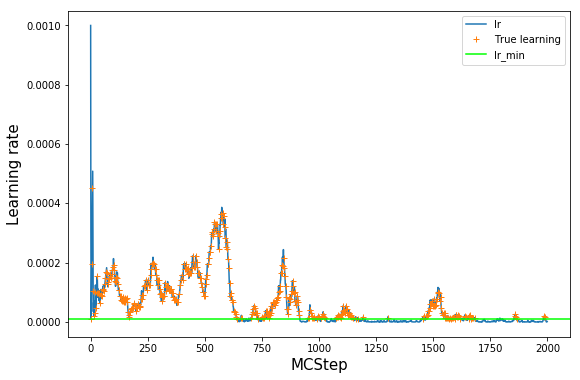

In [23]:
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

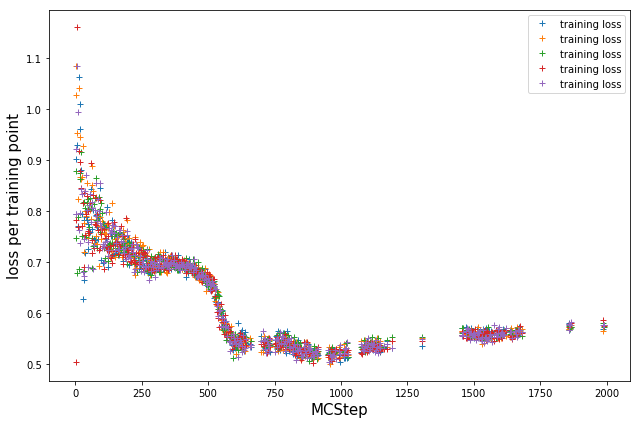

In [24]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

In [25]:
# get the number of accepts from OPS storage
accepts = []
for step in storage.steps:
    if step.change.canonical.accepted:
        accepts.append(1.)
    else:
        accepts.append(0.)

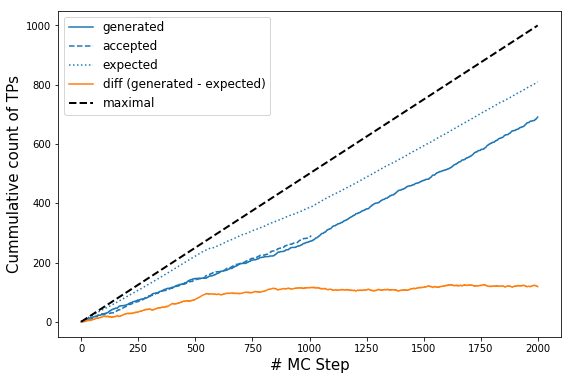

In [26]:
p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (generated - expected)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=12);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('# MC Step', size=15);

In [27]:
storage.sync_all()
storage.close()